# CICIDS2017 CNN Model Evaluation

This notebook loads the trained CNN model for CICIDS2017 and evaluates it on the test set.

**Model Path:** `../../results/models/best_cnn_cicids2017.pth`  
**Dataset:** CICIDS2017 (Test Split)

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd
import glob
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Data & Prepare Test Set
We need to replicate the preprocessing steps to ensure the test set is transformed exactly like the training phase.

In [2]:
# 1. Load Raw Data
DATA_PATH = '../../data/raw/cicids2017/'
all_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))
li = []
print("Loading data...")
for filename in all_files:
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_temp)
df = pd.concat(li, axis=0, ignore_index=True)
print(f"Total samples: {len(df):,}")
del li
gc.collect()

Loading data...
Total samples: 2,830,743


0

In [3]:
# 2. Preprocessing (Same as Training)
df.columns = df.columns.str.strip()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

drop_cols = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

def create_binary_label(label):
    if isinstance(label, str) and 'BENIGN' in label.upper():
        return 0
    return 1

df['binary_label'] = df['Label'].apply(create_binary_label)

y = df['binary_label'].values
X = df.drop(columns=['Label', 'binary_label']).values

del df
gc.collect()

# 3. Split (Stratified)
# Must adhere to Train (70%) / Val (15%) / Test (15%) split to recreate the scaler fit
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Free up Train/Val memory as we only need Scaler fit and Test data
print("Fitting scaler on training data...")
scaler = StandardScaler()
scaler.fit(X_train)

print("Transforming test data...")
X_test = scaler.transform(X_test)

# Use only X_test and y_test from here
del X_train, X_val, X_temp, y_train, y_temp, y_val
gc.collect()

print(f"Test set shape: {X_test.shape}")

Fitting scaler on training data...
Transforming test data...
Test set shape: (424182, 77)


## 2. Define Model Architecture
Must match the trained model.

In [4]:
class CNNClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(8)
        self.fc1 = nn.Linear(256 * 8, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

## 3. Load Model Weights

In [5]:
input_dim = X_test.shape[1]
model = CNNClassifier(input_dim=input_dim).to(device)

model_path = '../../results/models/best_cnn_cicids2017.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully!")
else:
    print(f"Error: Model file not found at {model_path}")

Model loaded successfully!


C:\Users\musab\AppData\Local\Temp\ipykernel_60392\1699481440.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

## 4. Evaluation

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    340698
      Attack       0.95      0.95      0.95     83484

    accuracy                           0.98    424182
   macro avg       0.97      0.97      0.97    424182
weighted avg       0.98      0.98      0.98    424182



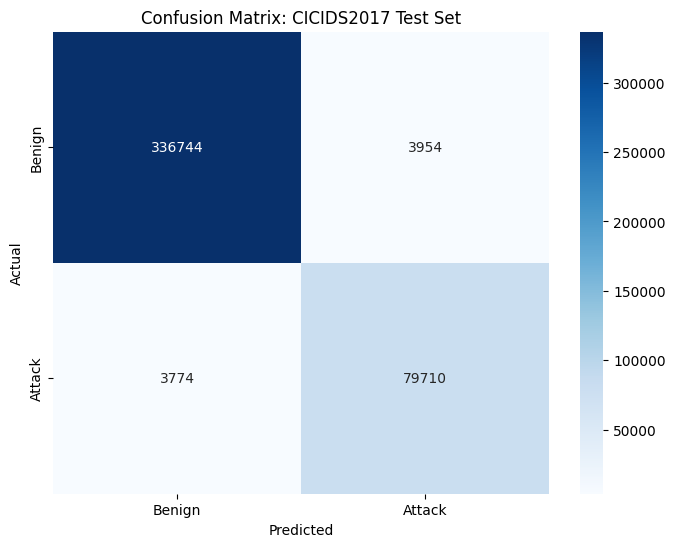

4377

In [6]:
# Prepare Test Loader
test_tensor_x = torch.FloatTensor(X_test).unsqueeze(1)
test_tensor_y = torch.LongTensor(y_test)
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Evaluate
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Attack']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CICIDS2017 Test Set')
plt.show()

torch.cuda.empty_cache()
import gc
gc.collect()